# ETRI Multiview DASH QoE Calculator

In [137]:
import numpy as np
import pandas as pd

f = open('../source/ns-3.34/contrib/etri_mvdash/multiviewvideo.csv')
mvinfo = [int(x) for x in f.readline().split()] 
f.close()

nViewpoints = mvinfo[0]
nSegments = mvinfo[1]
segDuration = mvinfo[2]
nRates = mvinfo[3]
# mvinfo[3] : # of rates/quality levels in the 1st viewpoint
#nstreams = sum(mvinfo[3:(mvinfo[0]+3)])

df = pd.read_csv('../source/ns-3.34/contrib/etri_mvdash/multiviewvideo.csv',sep="\t", header=None, skiprows=1)

In [139]:
df_rate_kbps = pd.DataFrame(df.mean().values.reshape((nViewpoints,nRates)).transpose()*8/segDuration, 
                   columns=["viewpoint_"+str(i+1) for i in range(nViewpoints)])
df_rate_kbps.head()

,viewpoint_1,viewpoint_2,viewpoint_3,viewpoint_4,viewpoint_5
0,0.176392,0.176643,0.176504,0.176356,0.176393
1,0.347921,0.348043,0.347769,0.348058,0.347989
2,0.901745,0.902152,0.901960,0.902652,0.899600
3,1.875856,1.876975,1.875812,1.875432,1.875122
4,3.938739,3.938752,3.935874,3.947304,3.941852


In [141]:
Rmin_vp = df_rate_kbps.iloc[0].values

Rn_vp = np.ones(nViewpoints)

for vp in range(1,8) :
    #n_vp.append(np.log2(df_rate_kbps.iloc[vp].values / Rmin_vp)+1, axis=0)
    #np.append(Rn_vp,np.log2(df_rate_kbps.iloc[vp].values / Rmin_vp)+1, axis=0)
    Rn_vp = np.vstack((Rn_vp, np.log2(df_rate_kbps.iloc[vp].values / Rmin_vp)+1) )

df_qscore = pd.DataFrame(Rn_vp, columns=df_rate_kbps.columns)
print(df_qscore)

   viewpoint_1  viewpoint_2  viewpoint_3  viewpoint_4  viewpoint_5
0     1.000000     1.000000     1.000000     1.000000     1.000000
1     1.979972     1.978424     1.978430     1.980838     1.980250
2     3.353933     3.352531     3.353364     3.355680     3.350493
3     4.410691     4.409497     4.409743     4.410660     4.410122
4     5.480875     5.478827     5.478912     5.484305     5.482011
5     6.422447     6.421530     6.423529     6.424772     6.421721
6     7.701736     7.701333     7.701070     7.702418     7.700329
7     8.860774     8.857494     8.857437     8.860308     8.859840


In [175]:
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt

df_play = pd.read_csv('../source/ns-3.34/contrib/etri_mvdash/playback.csv', sep="\t")
nSegments = df_play.shape[0]
df_play.head()

,tIndex,vpoint,Start,q_v1,q_v2,q_v3,q_v4,q_v5
0,0,0,1312272,0,0,0,0,0
1,1,0,3312272,0,0,0,0,0
2,2,0,5312272,1,0,0,0,0
3,3,2,7312272,3,0,0,0,0
4,4,2,9312272,3,0,0,0,0


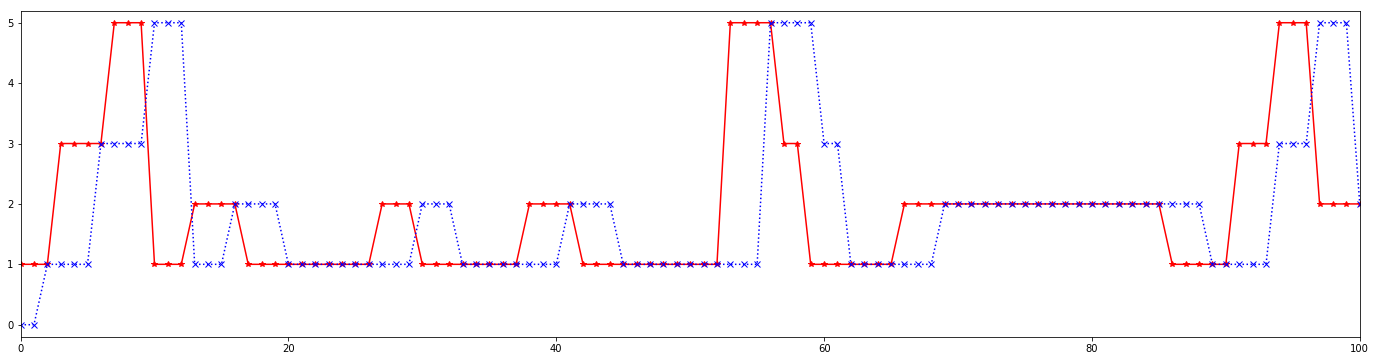

In [152]:
vp_high = ((df_play.iloc[:,3:] > 0)* [1,2,3,4,5]).T.sum().astype(int)

plt.figure(figsize=(24, 6));
plt.plot(df_play.tIndex, df_play.vpoint+1, 'r*-', df_play.tIndex, vp_high, 'bx:')
plt.axis([0,100,-0.2,5.2])
plt.show()

In [206]:
def q(viewpoint, rIndex) :
    return df_qscore.iloc[rIndex, viewpoint-1]

def QoE(vp, Vn_list, Rn_list, Tn_list, c_alpha, c_mu, c_lambda) :
    qscores = np.zeros(Rn_list.size)
    for i in range(Rn_list.size) :
        qscores[i] = q (vp+1, Rn_list[i])
    qoe_part1 = sum((Vn_list == vp) * qscores) + c_alpha * sum((Vn_list != vp) * qscores)
    qoe_part2 = sum((df_play.vpoint == vp)[1:] * Tn_list) \
                + c_alpha * sum((df_play.vpoint != vp)[1:] * Tn_list)    
    qoe_part3 = sum((df_play.vpoint == vp)[1:] * abs(np.diff(qscores))) \
                + c_alpha * sum((df_play.vpoint != vp)[1:] * abs(np.diff(qscores)))    
    q_total = qoe_part1 - c_mu * qoe_part2 - c_lambda * qoe_part3
    outstr = "[{}] QoE Total = {:>7.3f}, Part1 = {:>7.3f}, Part 2 = {:>7.3f}, Part 3 = {:>7.3f}".format(vp, \
                q_total, qoe_part1, qoe_part2, qoe_part3)
    print (outstr)
    return q_total
    

# Set coefficients

In [208]:
c_alpha = 0.1
c_mu = 2.66
c_lambda = 1.0

Tn_list = np.diff(df_play.Start) - segDuration
Vn_list = df_play.vpoint.values

multi_qoe = 0

for vp in range(nViewpoints) :
    Rn_list = df_play.iloc[:,3+vp].values
    multi_qoe += QoE(vp, Vn_list, Rn_list, Tn_list, c_alpha, c_mu, c_lambda)  
    
print("Multi-View Video QoE {:>7.3f}".format(multi_qoe))

[0] QoE Total = 316.841, Part1 = 434.723, Part 2 =   0.000, Part 3 = 117.882
[1] QoE Total = 131.392, Part1 = 178.535, Part 2 =   0.000, Part 3 =  47.143
[2] QoE Total =  57.815, Part1 =  81.521, Part 2 =   0.000, Part 3 =  23.706
[3] QoE Total =  25.342, Part1 =  26.683, Part 2 =   0.000, Part 3 =   1.340
[4] QoE Total = 105.049, Part1 = 137.105, Part 2 =   0.000, Part 3 =  32.056
Multi-View Video QoE 636.439


## Obsolete Codes

In [186]:
#Obsolete Code
vp = 0;
Rn_list = df_play.iloc[:,3+vp].values
Vn_list = df_play.vpoint.values

qscores = np.zeros(nSegments)
for i in range(nSegments) :
#    qscores[i] = q (vp+1, df_play.q_v1[i])
    qscores[i] = q (vp+1, Rn_list[i])

q_selected = sum((df_play.vpoint == vp) * qscores)
print(q_selected)
#print((df_play.vpoint == vp) * qscores)
q_unselected = sum((df_play.vpoint != vp) * qscores)
print(q_unselected)

print(sum((df_play.vpoint == vp)[1:] * abs(np.diff(qscores))))
print(sum((df_play.vpoint != vp)[1:] * abs(np.diff(qscores))))    

402.84015000258495
318.82944844055606
107.75595157474002
101.26143436265653
